In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler
import pandas as pd
import tensorflow as tf
import numpy as np

# Import our input dataset
df = pd.read_csv('outliers_removed.csv')
df.head()

,Year,Full Name,Age,Salary,ERA,Hits,Earned Runs,Strike Outs,Home Runs,Wins,Losses,Outs Pitched,Batters Faced by Pitcher,Games Finished,Weight,Height,League,Team,Games Started
0,1990,AbbottJim,23,185000,4.51,246,106,105,16,10,14,635,925,0,200,75,AL,CAL,33
1,1990,AbbottPaul,23,100000,5.97,37,23,25,0,0,5,104,162,0,185,75,AL,MIN,7
2,1990,AldredScott,22,100000,3.77,13,6,7,0,1,2,43,63,0,195,76,AL,DET,3
3,1990,AndersonAllan,26,300000,4.53,214,95,82,20,7,18,566,797,0,178,71,AL,MIN,31
4,1990,AppierKevin,23,100000,2.76,179,57,127,13,12,8,557,784,1,180,74,AL,KCA,24


In [2]:
# create bins for salary
sal_bins=pd.qcut(df['Salary'], q=3)

In [3]:
# see how many rows in each bin
sal_bins.value_counts()

(99999.999, 400000.0]       1525
(2246666.667, 9503543.0]    1507
(400000.0, 2246666.667]     1488
Name: Salary, dtype: int64

In [4]:
# Adding column + labels for salary bins
df['salary-bin'] = pd.qcut(
   df['Salary'], 
   q=3, 
   labels=['low', 'mid', 'high']
)
df.head()

,Year,Full Name,Age,Salary,ERA,Hits,Earned Runs,Strike Outs,Home Runs,Wins,Losses,Outs Pitched,Batters Faced by Pitcher,Games Finished,Weight,Height,League,Team,Games Started,salary-bin
0,1990,AbbottJim,23,185000,4.51,246,106,105,16,10,14,635,925,0,200,75,AL,CAL,33,low
1,1990,AbbottPaul,23,100000,5.97,37,23,25,0,0,5,104,162,0,185,75,AL,MIN,7,low
2,1990,AldredScott,22,100000,3.77,13,6,7,0,1,2,43,63,0,195,76,AL,DET,3,low
3,1990,AndersonAllan,26,300000,4.53,214,95,82,20,7,18,566,797,0,178,71,AL,MIN,31,low
4,1990,AppierKevin,23,100000,2.76,179,57,127,13,12,8,557,784,1,180,74,AL,KCA,24,low


In [5]:
### Drop unnecessary columns
df= df.filter(['Batters Faced by Pitcher','Outs Pitched','ERA','Strike Outs','Home Runs','Games Started', 'salary-bin'])
df.head()

,Batters Faced by Pitcher,Outs Pitched,ERA,Strike Outs,Home Runs,Games Started,salary-bin
0,925,635,4.51,105,16,33,low
1,162,104,5.97,25,0,7,low
2,63,43,3.77,7,0,3,low
3,797,566,4.53,82,20,31,low
4,784,557,2.76,127,13,24,low


In [15]:
# encode object features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_df = df.copy()
df['salary-bin'] = le.fit_transform(df['salary-bin'])

df.head()

,Batters Faced by Pitcher,Outs Pitched,ERA,Strike Outs,Home Runs,Games Started,salary-bin
0,925,635,4.51,105,16,33,1
1,162,104,5.97,25,0,7,1
2,63,43,3.77,7,0,3,1
3,797,566,4.53,82,20,31,1
4,784,557,2.76,127,13,24,1


In [16]:
# Split our preprocessed data into our features and target arrays
y = df[['salary-bin']].values
X = df.drop(["salary-bin"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

C:\Users\alyss\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 18
hidden_nodes_layer2 = 18
hidden_nodes_layer3 = 6


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 18)                126       
                                                                 
 dense_13 (Dense)            (None, 18)                342       
                                                                 
 dense_14 (Dense)            (None, 6)                 114       
                                                                 
 dense_15 (Dense)            (None, 3)                 21        
                                                                 
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compile the model
nn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=200)

In [21]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss*100:.2f}%, Accuracy: {model_accuracy*100:.2f}%")

36/36 - 0s - loss: 1.8235 - accuracy: 0.3398 - 102ms/epoch - 3ms/step
Loss: 182.35%, Accuracy: 33.98%


<AxesSubplot:>

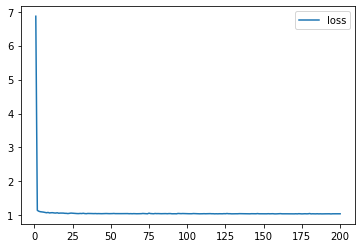

In [22]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

<AxesSubplot:>

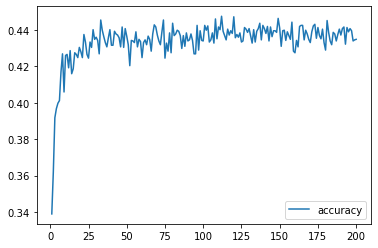

In [23]:
# Plot the accuracy
history_df.plot(y="accuracy")